# PySpark ile Çok Sınıflı Metin Sınıflandırma

## Gerekli kütüphaneler ve train verisinin yüklenmesi

In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder \
.master("local[4]") \
.appName("multiclass") \
.config("spark.executor.memory","4g") \
.config("spark.driver.memory","2g") \
.getOrCreate()

In [2]:
data = spark.read \
.option("header","True") \
.option("inferSchema","True") \
.option("sep",",") \
.csv("train.csv") \

# Kolonlar

In [3]:
data.columns

['Dates',
 'Category',
 'Descript',
 'DayOfWeek',
 'PdDistrict',
 'Resolution',
 'Address',
 'X',
 'Y']

### Kategori ve açıklama hariç tüm kolonları silelim

In [4]:
drop_list = ['Dates', 'DayOfWeek', 'PdDistrict', 'Resolution', 'Address', 'X', 'Y']

data = data.select([column for column in data.columns if column not in drop_list])

In [5]:
data.show(5)

+--------------+--------------------+
|      Category|            Descript|
+--------------+--------------------+
|      WARRANTS|      WARRANT ARREST|
|OTHER OFFENSES|TRAFFIC VIOLATION...|
|OTHER OFFENSES|TRAFFIC VIOLATION...|
| LARCENY/THEFT|GRAND THEFT FROM ...|
| LARCENY/THEFT|GRAND THEFT FROM ...|
+--------------+--------------------+
only showing top 5 rows



# Şema

In [6]:
data.printSchema()

root
 |-- Category: string (nullable = true)
 |-- Descript: string (nullable = true)



# En fazla girilen ilk 20 kategori

In [7]:
from pyspark.sql.functions import col

# by top 20 categories
data.groupBy("Category") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

+--------------------+------+
|            Category| count|
+--------------------+------+
|       LARCENY/THEFT|174900|
|      OTHER OFFENSES|126182|
|        NON-CRIMINAL| 92304|
|             ASSAULT| 76876|
|       DRUG/NARCOTIC| 53971|
|       VEHICLE THEFT| 53781|
|           VANDALISM| 44725|
|            WARRANTS| 42214|
|            BURGLARY| 36755|
|      SUSPICIOUS OCC| 31414|
|      MISSING PERSON| 25989|
|             ROBBERY| 23000|
|               FRAUD| 16679|
|FORGERY/COUNTERFE...| 10609|
|     SECONDARY CODES|  9985|
|         WEAPON LAWS|  8555|
|        PROSTITUTION|  7484|
|            TRESPASS|  7326|
|     STOLEN PROPERTY|  4540|
|SEX OFFENSES FORC...|  4388|
+--------------------+------+
only showing top 20 rows



# En fazla girilen ilk 20 açıklama

In [8]:
# by top 20 descriptions
data.groupBy("Descript") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

+--------------------+-----+
|            Descript|count|
+--------------------+-----+
|GRAND THEFT FROM ...|60022|
|       LOST PROPERTY|31729|
|             BATTERY|27441|
|   STOLEN AUTOMOBILE|26897|
|DRIVERS LICENSE, ...|26839|
|      WARRANT ARREST|23754|
|SUSPICIOUS OCCURR...|21891|
|AIDED CASE, MENTA...|21497|
|PETTY THEFT FROM ...|19771|
|MALICIOUS MISCHIE...|17789|
|   TRAFFIC VIOLATION|16471|
|PETTY THEFT OF PR...|16196|
|MALICIOUS MISCHIE...|15957|
|THREATS AGAINST LIFE|14716|
|      FOUND PROPERTY|12146|
|ENROUTE TO OUTSID...|11470|
|GRAND THEFT OF PR...|11010|
|POSSESSION OF NAR...|10050|
|PETTY THEFT FROM ...|10029|
|PETTY THEFT SHOPL...| 9571|
+--------------------+-----+
only showing top 20 rows



# Açıklama kolonundan stop words leri kaldırma, tokenize ve ventorize işlemleri

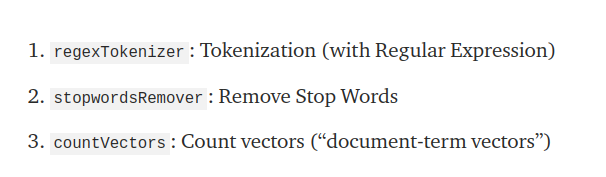

In [1]:
from IPython.display import Image
Image(filename='metin.png') 

In [9]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.classification import LogisticRegression

# regular expression tokenizer
regexTokenizer = RegexTokenizer(inputCol="Descript", outputCol="words", pattern="\\W")

# stop words
add_stopwords = ["http","https","amp","rt","t","c","the"] # standard stop words

stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(add_stopwords)

# bag of words count
countVectors = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=10000, minDF=5)

In [10]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
label_stringIdx = StringIndexer(inputCol = "Category", outputCol = "label")

# Pipeline ile yukarıdaki tüm ön hazırlık işlemlerini sırayla gerçekleştirelim

In [11]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors, label_stringIdx])

# Fit the pipeline to training documents.
pipelineFit = pipeline.fit(data)
dataset = pipelineFit.transform(data)

In [12]:
dataset.show(5)

+--------------+--------------------+--------------------+--------------------+--------------------+-----+
|      Category|            Descript|               words|            filtered|            features|label|
+--------------+--------------------+--------------------+--------------------+--------------------+-----+
|      WARRANTS|      WARRANT ARREST|   [warrant, arrest]|   [warrant, arrest]|(809,[17,32],[1.0...|  7.0|
|OTHER OFFENSES|TRAFFIC VIOLATION...|[traffic, violati...|[traffic, violati...|(809,[11,17,35],[...|  1.0|
|OTHER OFFENSES|TRAFFIC VIOLATION...|[traffic, violati...|[traffic, violati...|(809,[11,17,35],[...|  1.0|
| LARCENY/THEFT|GRAND THEFT FROM ...|[grand, theft, fr...|[grand, theft, fr...|(809,[0,2,3,4,6],...|  0.0|
| LARCENY/THEFT|GRAND THEFT FROM ...|[grand, theft, fr...|[grand, theft, fr...|(809,[0,2,3,4,6],...|  0.0|
+--------------+--------------------+--------------------+--------------------+--------------------+-----+
only showing top 5 rows



# Verimizi Train ve Test olarak bölelim (%70-%30)

In [13]:
### Randomly split data into training and test sets. set seed for reproducibility
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Training Dataset Count: 614303
Test Dataset Count: 263746


# **Logistic Regression**

In [14]:
# Build the model
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)

# Train model with Training Data
lrModel = lr.fit(trainingData)

In [15]:
predictions = lrModel.transform(testData)

predictions.filter(predictions['prediction'] == 0) \
    .select("Descript","Category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+-------------+------------------------------+-----+----------+
|                      Descript|     Category|                   probability|label|prediction|
+------------------------------+-------------+------------------------------+-----+----------+
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8737986785524351,0.02009...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8737986785524351,0.02009...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8737986785524351,0.02009...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8737986785524351,0.02009...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8737986785524351,0.02009...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8737986785524351,0.02009...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8737986785524351,0.02009...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8

In [16]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.9717430326832268

# **Logistic Regression using TF-IDF Features**

In [17]:
from pyspark.ml.feature import HashingTF, IDF

# Add HashingTF and IDF to transformation
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=10000)
idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms

# Redo Pipeline
pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, hashingTF, idf, label_stringIdx])

In [18]:
pipelineFit = pipeline.fit(data)
dataset = pipelineFit.transform(data)

### Randomly split data into training and test sets. set seed for reproducibility
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)

# Build the model
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)

# Train model with Training Data
lrModel = lr.fit(trainingData)

In [19]:
predictions = lrModel.transform(testData)

predictions.filter(predictions['prediction'] == 0) \
    .select("Descript","Category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+-------------+------------------------------+-----+----------+
|                      Descript|     Category|                   probability|label|prediction|
+------------------------------+-------------+------------------------------+-----+----------+
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8741091504211743,0.02002...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8741091504211743,0.02002...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8741091504211743,0.02002...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8741091504211743,0.02002...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8741091504211743,0.02002...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8741091504211743,0.02002...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8741091504211743,0.02002...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8

In [20]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.9716679249019039

# **Cross-Validation**

In [21]:
pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors, label_stringIdx])

pipelineFit = pipeline.fit(data)
dataset = pipelineFit.transform(data)
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)

# Build the model
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1, 0.3, 0.5]) # regularization parameter
             .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.2]) # Elastic Net Parameter (Ridge = 0)
#            .addGrid(model.maxIter, [10, 20, 50]) #Number of iterations
#            .addGrid(idf.numFeatures, [10, 100, 1000]) # Number of features
             .build())

# Create 5-fold CrossValidator
cv = CrossValidator(estimator=lr, \
                    estimatorParamMaps=paramGrid, \
                    evaluator=evaluator, \
                    numFolds=5)

# Run cross validations
cvModel = cv.fit(trainingData)
# this will likely take a fair amount of time because of the amount of models that we're creating and testing

# Use test set here so we can measure the accuracy of our model on new data
predictions = cvModel.transform(testData)

# cvModel uses the best model found from the Cross Validation
# Evaluate best model
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.991419899490691

# Naive Bayes

In [22]:
from pyspark.ml.classification import NaiveBayes

# create the trainer and set its parameters
nb = NaiveBayes(smoothing=1)

# train the model
model = nb.fit(trainingData)

In [23]:
predictions = model.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("Descript","Category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+----------------------------+-------------+------------------------------+-----+----------+
|                    Descript|     Category|                   probability|label|prediction|
+----------------------------+-------------+------------------------------+-----+----------+
|PETTY THEFT FROM LOCKED AUTO|LARCENY/THEFT|[0.9999999999860665,1.26997...|  0.0|       0.0|
|PETTY THEFT FROM LOCKED AUTO|LARCENY/THEFT|[0.9999999999860665,1.26997...|  0.0|       0.0|
|PETTY THEFT FROM LOCKED AUTO|LARCENY/THEFT|[0.9999999999860665,1.26997...|  0.0|       0.0|
|PETTY THEFT FROM LOCKED AUTO|LARCENY/THEFT|[0.9999999999860665,1.26997...|  0.0|       0.0|
|PETTY THEFT FROM LOCKED AUTO|LARCENY/THEFT|[0.9999999999860665,1.26997...|  0.0|       0.0|
|PETTY THEFT FROM LOCKED AUTO|LARCENY/THEFT|[0.9999999999860665,1.26997...|  0.0|       0.0|
|PETTY THEFT FROM LOCKED AUTO|LARCENY/THEFT|[0.9999999999860665,1.26997...|  0.0|       0.0|
|PETTY THEFT FROM LOCKED AUTO|LARCENY/THEFT|[0.9999999999860665,1.2699

In [24]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.9937211787626278

# Random Forest

In [25]:
from pyspark.ml.classification import RandomForestClassifier

# Create an initial RandomForest model.
rf = RandomForestClassifier(labelCol="label", \
                            featuresCol="features", \
                            numTrees = 100, \
                            maxDepth = 4, \
                            maxBins = 32)

# Train model with Training Data
rfModel = rf.fit(trainingData)

In [26]:
predictions = rfModel.transform(testData)

predictions.filter(predictions['prediction'] == 0) \
    .select("Descript","Category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+----------------------------+-------------+------------------------------+-----+----------+
|                    Descript|     Category|                   probability|label|prediction|
+----------------------------+-------------+------------------------------+-----+----------+
|PETTY THEFT FROM LOCKED AUTO|LARCENY/THEFT|[0.5498302555414141,0.07913...|  0.0|       0.0|
|PETTY THEFT FROM LOCKED AUTO|LARCENY/THEFT|[0.5498302555414141,0.07913...|  0.0|       0.0|
|PETTY THEFT FROM LOCKED AUTO|LARCENY/THEFT|[0.5498302555414141,0.07913...|  0.0|       0.0|
|PETTY THEFT FROM LOCKED AUTO|LARCENY/THEFT|[0.5498302555414141,0.07913...|  0.0|       0.0|
|PETTY THEFT FROM LOCKED AUTO|LARCENY/THEFT|[0.5498302555414141,0.07913...|  0.0|       0.0|
|PETTY THEFT FROM LOCKED AUTO|LARCENY/THEFT|[0.5498302555414141,0.07913...|  0.0|       0.0|
|PETTY THEFT FROM LOCKED AUTO|LARCENY/THEFT|[0.5498302555414141,0.07913...|  0.0|       0.0|
|PETTY THEFT FROM LOCKED AUTO|LARCENY/THEFT|[0.5498302555414141,0.0791

In [27]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.680496624716238

# Bu problem için en iyi sonucu Logistic regresyon ve Naive Bayes verdi

# **Faydalı olması dileğiyle**